# Deep Learning for Aqueous Solubility Prediction

<a rel="license" href="https://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="width=50" src="https://licensebuttons.net/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

**Authors**:
- Dr Antonia Mey (antonia.mey@ed.ac.uk)
- Rohan Gorantla (rohan.gorantla@ed.ac.uk)

**About aqueous solubility prediction task**:

Water is a ubiquitous solvent in both chemistry and life, so it's not surprising that the solubility of compounds in water is crucial in various fields, such as drug discovery, paint and coatings, the environment, and energy storage. However, measuring and predicting the aqueous solubility of compounds is a challenging and ongoing problem in chemistry. To tackle this, various data-driven prediction models have been created to supplement traditional physics-based methods. Despite the many efforts made over the years, there are still difficulties in developing a solubility prediction model that is accurate enough for many practical applications.

**Task:** Train a Deep learning model to predict if a given molecule is soluble in water or not. The input data consists of solubility values and 1-D SMILES strings for the molecules.

---



**Learning Objectives**:

* Using RDKit to extract features from molecular data in SMILES format.
* Preparing the data for training and testing of a given deep learning model.
* To build and train deep neural networks for solubility prediction from SMILES data using Pytorch.
* Tuning the neural network parameters to improve the learning of the model for the given solubilitity prediction task.


## Google Colab installs

<div class="alert alert-warning">
The following cell installs necessary packages and downloads data if you are running this tutorial using Google Colab.<br>
<b><i>Run this cell only if you are using Google Colab!</i></b></div>

In [3]:
!if [ -n "$COLAB_RELEASE_TAG" ]; then pip install condacolab; fi
import condacolab
condacolab.install()

import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!
✨🍰✨ Everything looks OK!


In [4]:
!mamba install pytorch torchvision torchinfo -c pytorch
!mamba install -c conda-forge rdkit


Looking for: ['pytorch', 'torchvision', 'torchinfo']

pytorch/linux-64                                            Using cache
pytorch/noarch                                              Using cache
conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_abi 3.11.* *cp311*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  All requested packages already installed


Looking for: ['rdkit']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_abi 3.11.* *cp311*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  All requested packages already installed



In [5]:
# copy over data repository
!if [ -n "$COLAB_RELEASE_TAG" ]; then git clone https://github.com/Edinburgh-Chemistry-Teaching/ATCP-ML-workshop; fi
import os
os.chdir(f"ATCP-ML-workshop{os.sep}Workshops{os.sep}workshop_03")

Cloning into 'ATCP-ML-workshop'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 164 (delta 24), reused 26 (delta 8), pack-reused 114 (from 1)
Receiving objects: 100% (164/164), 109.19 MiB | 14.24 MiB/s, done.
Resolving deltas: 100% (68/68), done.
Updating files: 100% (36/36), done.


To get started with this tutorial, let's install and importing some packages.

In [6]:
!pip install rdkit torchinfo

In [7]:
# Imports
import os, math
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve,auc


# Needed for fingerprints
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import DataStructs,AllChem
from rdkit.Chem import rdmolfiles

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

#Torch
import torch
import torch.nn as nn
import torch.optim as optim
from   torchinfo import summary
from   torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

## 1. Introduction- Data Prepartion and Exploratory Data Anlaysis

In this tutorial we will use the solubility prediciton data from AqSolDB dataset to train the DL models.

**Data Source**: Sorkun, M.C., Khetan, A. & Er, S. AqSolDB, a curated reference set of aqueous solubility and 2D descriptors for a diverse set of compounds. Sci Data 6, 143 (2019). https://doi.org/10.1038/s41597-019-0151-1

Let's begin by loading the AqSolDB dataset from the csv file in the data folder.

In [8]:
# Load the dataset into a dataframe
data_path='data'
if os.environ.get('COLAB_RELEASE_TAG') is None:
    data_path = os.path.join('data')

solubility = os.path.join(data_path,'solubility-dataset.csv')
df = pd.read_csv(solubility)

In [9]:
df

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.000000,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.000000,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.000000,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.000000,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.000000,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9977,I-84,tetracaine,InChI=1S/C15H24N2O2/c1-4-5-10-16-14-8-6-13(7-9...,GKCBAIGFKIBETG-UHFFFAOYSA-N,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000,0.000000,1,G1,264.369,...,8.0,106.0,1.0,0.0,0.0,1.0,41.57,115.300645,2.394548e+00,374.236893
9978,I-85,tetracycline,InChI=1S/C22H24N2O8/c1-21(31)8-5-4-6-11(25)12(...,OFVLGDICTFRJMM-WESIUVDSSA-N,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000,0.000000,1,G1,444.440,...,2.0,170.0,1.0,0.0,3.0,4.0,181.62,182.429237,2.047922e+00,1148.584975
9979,I-86,thymol,InChI=1S/C10H14O/c1-7(2)9-5-4-8(3)6-10(9)11/h4...,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000,0.019222,3,G5,150.221,...,1.0,60.0,1.0,0.0,0.0,1.0,20.23,67.685405,3.092720e+00,251.049732
9980,I-93,verapamil,"InChI=1S/C27H38N2O4/c1-20(2)27(19-28,22-10-12-...",SGTNSNPWRIOYBX-UHFFFAOYSA-N,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000,0.000000,1,G1,454.611,...,13.0,180.0,2.0,0.0,0.0,2.0,63.95,198.569223,2.023333e+00,938.203977


<div class="alert alert-success">
<b>Task 1a.</b> From the data frame above, print the number of compounds and list of features (columns) in the dataset.</div>

In [11]:
# Your solution here
comp = len(df)
feat = df.columns.values
print(f'Number of compounds: {comp}')
print(f'Features present: {feat}')

Number of compounds: 9982
Features present: ['ID' 'Name' 'InChI' 'InChIKey' 'SMILES' 'Solubility' 'SD' 'Ocurrences'
 'Group' 'MolWt' 'MolLogP' 'MolMR' 'HeavyAtomCount' 'NumHAcceptors'
 'NumHDonors' 'NumHeteroatoms' 'NumRotatableBonds' 'NumValenceElectrons'
 'NumAromaticRings' 'NumSaturatedRings' 'NumAliphaticRings' 'RingCount'
 'TPSA' 'LabuteASA' 'BalabanJ' 'BertzCT']


<details>
<summary> <mark> Solution:</mark> </summary>

```Python
print(f"Number of compounds in the dataset: {df.shape[0]}" )
print(f"Dataset columns: {list(df.columns)}" )
```

</details>

<div class="alert alert-success">
<b>Task 1b.</b> What are the two features that are required in our task to predict solubility of the molecule from SMILES representation ?</div>

In [ ]:
# Solubility and SMILES

<details>
<summary> <mark> Solution: </mark> </summary>

Features:
- 'SMILES'
- 'Solubility'

</details>

The chosen
unit of solubility in this dataset is LogS, where S is the aqueous solubility in mol/L (or M). Units such as g/L and mg/L were converted to LogS using the molecular mass of the compounds.

<div class="alert alert-success">
<b>Task 1c.</b> Plot a histogram to analyse the distribution of 'Solubility' measurement across the entire dataset. You can use seaborn histplot for this task. </div>

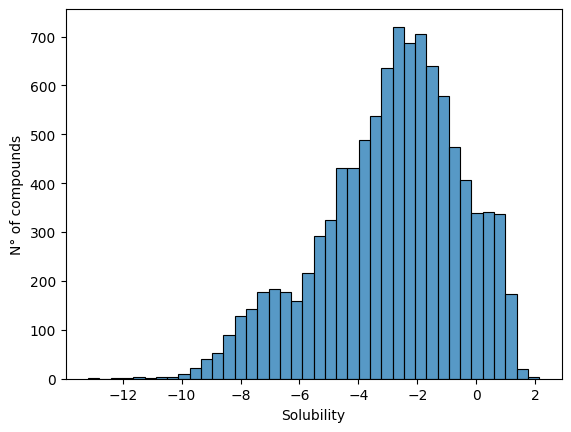

In [15]:
## Your solution here
sns.histplot(df['Solubility'], bins = 40)
plt.ylabel('N° of compounds')
plt.show()

<details>
<summary> <mark> Solution: </mark> </summary>

```Python
sns.histplot(df['Solubility'],bins=20)
plt.ylabel('Number of Compunds')
plt.show()
```

</details>

Now we want to categorise the Solubility data into two classes-- 0 for insoluble and 1 for soluble compounds. These compounds can be classified according to solubility values (LogS).

Compounds with 0 and higher solubility value are highly soluble, those in the range of 0 to −2 are soluble, those in the range of −2 to −4 are slightly soluble and insoluble if less than −4.

In [27]:
df["isSoluble"] = (df.Solubility > -2
                   ).astype(int)


<div class="alert alert-success">
<b>Task 1d.</b> Let's check the number of soluble and not soluble molecules. What happens if you change the cut off? </div>

In [28]:
## Your solution here
sol_comp = 0
insol_comp = 0

# if df['isSoluble'] == 1 wrong -> df['isSoluble'] is whole column/series, not single value I'm iterating over
# use sol instead -> denotes single boolean
for sol in df['isSoluble']:
  if sol == 1:
    sol_comp += 1
  else:
    insol_comp += 1

#print outside loop, otherwise will get printed after each count
print(f'N° of soluble compounds: {sol_comp}')
print(f'N° of insoluble compounds: {insol_comp}')

#if -2 is cut off -> sol: 3896, insol: 6086
#if -4 -> sol: 7103, insol: 2879
#if 0 -> sol: 1056, insol: 8926

N° of soluble compounds: 3896
N° of insoluble compounds: 6086


<details>
<summary> <mark> Solution: </mark> </summary>

```Python
df["isSoluble"] = (df.Solubility > -3).astype(int)
print(df.isSoluble.value_counts())
```
</details>

<div class="alert alert-success">
<b>Task 1e.</b> How does solubility correlate with molecular weight? Do distributions overlap between compounds that were classified as soluble and not soluble?  </div>

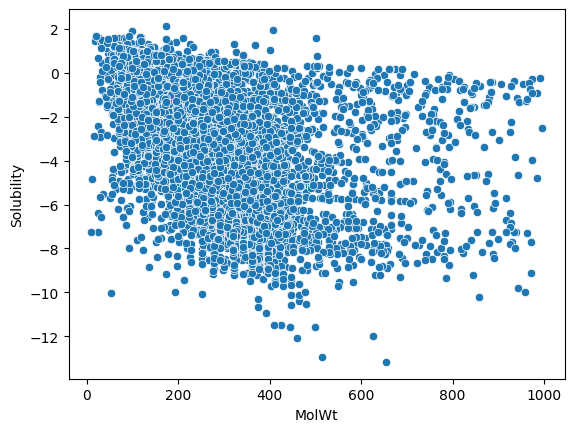

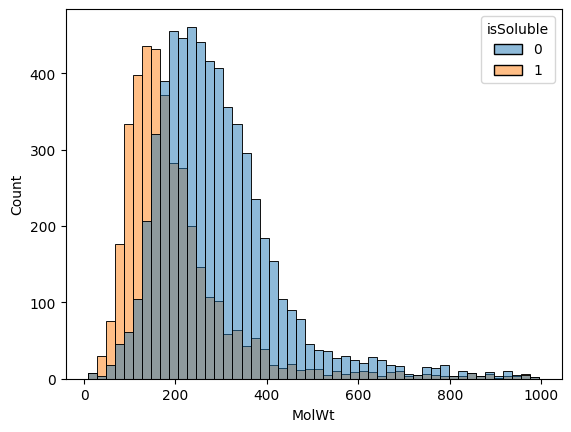

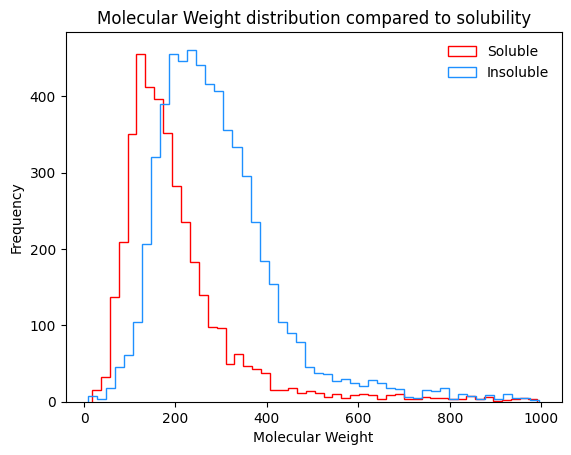

In [39]:
## Your solution here
sns.scatterplot(x='MolWt', y='Solubility', data = df[df.MolWt < 1000])
plt.show()

#faster way
sns.histplot(x="MolWt", hue='isSoluble', data=df[df.MolWt < 1000], bins=50);
plt.show()

filt_df = df[df['MolWt'] < 1000]
plt.hist(filt_df[filt_df['isSoluble'] == 1]['MolWt'], histtype="step", label="Soluble", bins=50, color="red")
plt.hist(filt_df[filt_df['isSoluble'] == 0]['MolWt'], histtype="step", label="Insoluble", bins=50, color="dodgerblue")
plt.xlabel("Molecular Weight")
plt.ylabel("Frequency")
plt.legend(frameon=False)
plt.title('Molecular Weight distribution compared to solubility')
plt.show()


<details>
<summary> <mark> Solution: </mark> </summary>

```Python
# Looking at correlation
sns.scatterplot(x="MolWt", y='Solubility', data=df[df.MolWt < 1000])
# Looking at overlap of soluble and not soluble distributions
sns.histplot(x="MolWt", hue='isSoluble', data=df[df.MolWt < 1000], bins=40);
```
</details>

## 2. Data Preprocessing- Feature extraction and splitting the datasets

Molecular Fingerprinting- ECFP take a look at [J. Chem. Inf. Model. 2010, 50, 5, 742–754](https://pubs.acs.org/doi/10.1021/ci100050t) for more details about molecular fingerprints.

In [55]:
# Convert SMILES strings to ECFP fingerprints
def get_fingerprints(smiles):
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return np.zeros(1024, dtype=np.float32)
    generator = AllChem.GetMorganGenerator(radius=2, fpSize=1024)
    fp = generator.GetFingerprint(m)
    #fp = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
    arr = np.zeros((1,1024), dtype=np.float32)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

From the dataframe above, we will now select the input i.e., SMILES string and initialize it to the variable **X** and the binary solubility scores to the variable **y**. We will then get the Morgan fingerprints for the input **X**.

In [56]:
X = df["SMILES"]
y = np.array(df["isSoluble"]) # label
#Get ECFP Fingerprints
X1 = X.apply(get_fingerprints).apply(lambda x: np.array(x, dtype=np.float32))
X1 = np.concatenate(X1.values)
X1 = X1.reshape(-1, 1024)

[14:56:15] WARNING: not removing hydrogen atom without neighbors
[14:56:15] WARNING: not removing hydrogen atom without neighbors
[14:56:15] WARNING: not removing hydrogen atom without neighbors
[14:56:15] WARNING: not removing hydrogen atom without neighbors
[14:56:15] WARNING: not removing hydrogen atom without neighbors
[14:56:15] WARNING: not removing hydrogen atom without neighbors
[14:56:15] WARNING: not removing hydrogen atom without neighbors
[14:56:15] WARNING: not removing hydrogen atom without neighbors
[14:56:15] WARNING: not removing hydrogen atom without neighbors
[14:56:15] WARNING: not removing hydrogen atom without neighbors
[14:56:15] WARNING: not removing hydrogen atom without neighbors
[14:56:15] WARNING: not removing hydrogen atom without neighbors
[14:56:15] WARNING: not removing hydrogen atom without neighbors
[14:56:15] WARNING: not removing hydrogen atom without neighbors
[14:56:15] WARNING: not removing hydrogen atom without neighbors
[14:56:15] WARNING: not r

Now we have **X1** with fingerprints for all the molecules in the dataset and corresponding solubility scores.

<div class="alert alert-success">
<b>Task 2.</b> Explore what you see in X1 in ab it more detail! </div>

In [57]:
## Your code here
np.shape(X1)

(9982, 1024)

<details>
<summary> <mark> Solution: </mark> </summary>

For example you can look at the shape or number of 1s and 0s in your feature vector
    
```Python
np.shape(X1)
```
</details>

Now we have **X1** with fingerprints for all the molecules in the dataset and corresponding solubility scores.

<div class="alert alert-success">
<b>Task 2a.</b> Split X and y into train, test and validation sets using scikit-learn. Use 80% data for training and 20% data for testing; You can use 20% of the training data for validation set. </div>

In [60]:
from sklearn.model_selection import train_test_split

# X1 is the training data and our y is the label

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2)

# Split the train data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

<details>
<summary> <mark> Solution: </mark> </summary>
    
```Python
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2)

# Split the train data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
```
</details>

We will now have to convert the `train`, `val` and `test` sets into `tensors` and then use PyTorch `DataLoader` to wrap these samples for training the DL models.

## 3. Use a Random Forest to classify the data

Let's start by training a Random Forests Classifier (RF) using the training set we have just assembled. The RF is constituted by a collection of decision trees, each trained on a subset of data ("data bagging") and subset of features ("features bagging"). The key philosophy behind RF is that a collection of weak classifiers (here, decision trees) makes a strong classifier. After training, classification is done by voting: each decision tree proposes a classification, and the most voted class wins. A key advantage of this approach is that RF does not overfit.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=10)
RF.fit(X_train, y_train)

Let's now assess its performance against the test set.

In [ ]:
r = RF.predict(X_test)
success = np.sum((r-y_test)==0)
percent = float(success)/len(y_test)*100
print(f'Success of test set: {percent}%')

To see which features are deemed the most useful for a successful classification, we can observe their importance.

In [ ]:
importances = RF.feature_importances_
importances_std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)

sorted_indices = np.argsort(importances)[-10:][::-1]
top_values = np.array(importances)[sorted_indices]
top_std_devs = np.array(importances_std)[sorted_indices]
colors = ['red' if i == 0 else 'skyblue' for i in range(10)]

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(range(10), top_values, xerr=top_std_devs, align='center', color=colors, capsize=5)
ax.set_yticks(range(10))
ax.set_yticklabels(sorted_indices)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature index')
ax.set_title('Top 10 important features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

<div class="alert alert-success">
<b>Task 3.</b> Can you change the random forest classifier settings to get better performance? </div>

In [ ]:
# Your Solution here


<details>
<summary> <mark> Solution: </mark> </summary>

```Python
# Change hyperparameters for the random forest model
RF = RandomForestClassifier(n_estimators=46, min_samples_split=2, max_samples=0.92)
RF.fit(X_train, y_train)
r = RF.predict(X_test)
success = np.sum((r-y_test)==0)
percent = float(success)/len(y_test)*100
print(f'Success of test set: {percent}%')
```
</details>

## 4. Prep of data for Neural network training

In [ ]:
# Convert your data into tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)

# Wrap your data in TensorDataset
train_dataset = TensorDataset(X_train, y_train)

# Create the dataloaders
batch_size = 128
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

<div class="alert alert-success">
<b>Task 4.</b> Similar to the train set as shown in the cell above, prepare the testloader and validation loader. </div>

In [ ]:
# Convert your data into tensors
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val =
X_test =
y_test =

# Wrap your data in TensorDataset
val_dataset =
test_dataset =

# Create the dataloaders
batch_size = 128
valloader = DataLoader()
testloader =

<details>
<summary> <mark> Solution: </mark> </summary>
    
```Python
# Convert your data into tensors
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

# Wrap your data in TensorDataset
val_dataset = TensorDataset(X_val, y_val)
test_dataset= TensorDataset(X_test, y_test)

# Create the dataloaders
batch_size = 128
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
```
</details>

## 5. Training the Deep Neural Network on SMILES data

### 5.1. Defining the DNN model
Now let's get started by defining a 5-layer deep neural network which takes in an input a 1024 dimensions ECFP fingerprint obtained from the corresponding SMILES string.

This code defines a class named DNN which extends PyTorch's `nn.Module` class. The DNN class is used to build a deep neural network model. The class has two main parts: the constructor `__init__` and the `forward` method.

In the constructor, we first call the `super()` method to initialize the parent class `nn.Module`. Then, we create five fully connected linear layers using `nn.Linear` from the PyTorch's nn module. The first layer `fc1` has 1024 inputs and 512 outputs, the second layer `fc2` has 512 inputs and 256 outputs, the third layer `fc3` has 256 inputs and 128 outputs, the fourth layer `fc4` has 128 inputs and 64 outputs, and the final layer `fc5` has 64 inputs and 2 outputs.

In the forward method, we define the forward pass of the network. We first apply the `F.relu` activation function to the outputs of each layer, which applies the rectified linear unit (ReLU) activation function. After applying activation, we apply the `F.softmax `function to the output of the final layer to get probabilities for each class. The final output of the forward method is the probability distribution over the two classes.

In [ ]:
# Define the DNN model
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.softmax(self.fc5(x), dim=1) # Use softmax activation to get probabilities for each class
        return x


<div class="alert alert-success">
<b>Task 5a.</b> What is an activation function? Why do you think we need an activation function in a deep neural network? Give some examples of activation functions. </div>

<details>
<summary> <mark> Solution: </mark> </summary>

An activation function is a non-linear function applied to the output of each neuron in a deep neural network. It transforms the linear combination of inputs and weights into a non-linear representation, which allows the neural network to learn non-linear relationships in the data.

Examples: Sigmoid, ReLU, Tanh, Leaky ReLU, etc.
</details>

Next, we will initialize the `DNN` model and define the loss function and optimizer. The loss function is used to measure whether the model is doing a good job of learning the training data. It is then averaged over every sample in the training set.

Now that we have a way to measure how well the model works, we need a way to improve it. We want to search for parameter values that minimize the average loss over the training set in each step, for this, we need an optimizer.  The learning rate `lr` determines how much the parameters change on each step.  

In [ ]:
# Initialize the model, loss function, and optimizer
model = DNN()
criterion = nn.CrossEntropyLoss() # Use cross entropy loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Use Adam optimizer

Let's see the number of parameters that are present in the simple DNN we defined above.

In [ ]:
summary(model)

### 5.2. Training the DNN model
Now let's start training the DNN model. We will train this model over 50 epochs and save the training loss and validation loss to monitor the model performance.

In [ ]:
train_loss = []
val_loss = []
num_epochs = 50

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainloader)
    train_loss.append(avg_train_loss)

    val_running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            val_batch_loss = criterion(outputs, labels.long())
            val_running_loss += val_batch_loss.item()

    avg_val_loss = val_running_loss / len(valloader)
    val_loss.append(avg_val_loss)


**Training loss** and **validation loss** are metrics used in deep learning to evaluate the performance of a model during training.

Training loss measures the error between the predicted output and the true output on the training data. It helps to determine how well the model is learning from the training data and whether it is overfitting or underfitting. If the training loss is decreasing, it means the model is learning and improving.

Validation loss, on the other hand, measures the error between the predicted output and the true output on a validation dataset, which is separate from the training data. The validation loss provides an estimate of the model's generalization ability, that is, its ability to perform well on new, unseen data. A high validation loss indicates overfitting to the training data, which means the model is not generalizing well to new data.

In general, monitoring both the training loss and the validation loss is important for guiding the training process and selecting a well-performing model. Let's see how the `DNN` model learned over 50 epochs.

In [ ]:
# Plot the training and validation loss
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.plot(range(num_epochs), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<div class="alert alert-success">
<b>Task 5b.</b> From the above plot, what do you think about the model's learning over 50 epochs? </div>

### 5.3. Testing the DNN model

Model testing is an important step after training a machine learning model because it provides an estimate of how well the model is likely to perform on unseen data. This is important because a model that performs well on the training data may not necessarily perform well on unseen data, which can result in poor performance and unreliable results. Testing helps to identify overfitting, which occurs when a model is too complex and has learned the training data too well, causing it to perform poorly on new data. Model testing also helps to estimate the generalization error, which is a measure of how well the model is expected to perform on unseen data. By testing the model, we can evaluate its performance and identify any areas where the model needs improvement.

In [ ]:
# Test the model on the test data
correct = 0
total = 0
predictions = []
true_labels = []
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        inputs, target = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) # Get the class with the highest probability
        total += target.size(0)
        correct += (predicted == target.long()).sum().item() # Convert target to long and compare
        predictions += predicted.tolist()
        true_labels += target.tolist()

<div class="alert alert-success">
<b>Task 5c.</b> We have calculated above the correct predictions. Can you print the accuracy of the model in % on test data using the variables defined above? </div>

<details>
<summary> <mark> Solution: </mark> </summary>


```Python
accuracy = correct / total
print(f'Accuracy of the network on the test data: {(100 * accuracy):.2f}%'))
```



</details>

Let's define a confusion matrix. It is a plot that is used to evaluate the performance of a classification algorithm. It displays the number of correct and incorrect predictions made by the algorithm in a tabular format. The matrix is used to determine the true positive rate, false positive rate, accuracy, precision, and recall, which are all metrics that help in evaluating the performance of the classifier.

In [ ]:
# Plot confusion matrix
cf_matrix= confusion_matrix(true_labels, predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

<div class="alert alert-success">
<b>Task 5d.</b> From the confusion matrix comment on the performance on the test set. Do you think the model is underfitting or overfitting?</div>

In [ ]:
## Your solution here:


Receiver Operator Characteristic (ROC) curves are a good way to assess how good your binary classifier is versus random guessing.
Take a look [here](https://dmol.pub/ml/classification.html#receiver-operating-characteristic-curve) for more information on ROC curves. And here is some information on how to compute these with [scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html).  

<div class="alert alert-success">
<b>Task 5e.</b> Plot an ROC curve from <code>sklearn</code> using true_labels and predictions defined above.</div>

In [ ]:
## Your solution here:


<details>
<summary> <mark> Solution: </mark> </summary>

```Python
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
```
</details>

### 5.4. Modelling choices and Hyperparameter Optimization

By now you have probably noticed that there are a lot of choices to make, even when using a supposedly simple DL model with a “generic” learning algorithm. Examples include:
- The number of layers in the model
- The loss function
- The number of training steps to perform
- The learning rate to use during *training*



<div class="alert alert-success">
<b>Task 5f.</b> Using the code above retrain a new DNN model with differnt learning rates for example 0.1 and 0.0001. Compare the performances of these models. Plot confusion matrices for both these learning rates and comment on the model fits.</div>

In [ ]:
# Your solution here:


<div class="alert alert-success">
<b>Task 5g.</b> Using the code above retrain a new DNN model for 100 and 200 epochs. Does this help in model's learning? Plot confusion matrices for both these epoch settings and comment on the model fits.</div>

In [ ]:
# Your solution here:


<div class="alert alert-success">
<b>Task 5h.</b> Using the code above define a new DNN model architecture called `DNN_new` with 3 layers. Plot confusion matrices for the new model.</div>

## 6. Extra Topic: Convolutional Neural Networks

We define a new Deep Learning variant called **1D Convolutional Neural Network (CNN)** below.
CNN is a type of deep learning model that is typically used for image and signal processing tasks.

In this code, the model takes a 1D input signal of length 1024 and performs a series of convolution, pooling and fully connected operations to classify the signal into one of two classes. The `conv1` and `conv2` layers are 1D convolutional layers that apply filters to the input signal to extract features. The `pool1` and `pool2` layers are max-pooling layers that down-sample the input signal. The `fc1` and `fc2` layers are fully connected layers that perform classification based on the extracted features. The `softmax` activation is applied to the output to produce probabilities for each class. This gives us the classification into soluble and insoluble molecules.

The steps are similar to DNN model.

In [ ]:
# Define the 1D CNN model
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 256, 128)
        self.fc2 = nn.Linear(128, 2)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = x.reshape(-1, 1, 1024)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.reshape(-1, 32 * 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [ ]:
# Initialize the model, loss function, and optimizer
model_cnn = CNN1D()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

In [ ]:
summary(model_cnn)

In [ ]:
# Train the CNN model and keep track of validation loss
train_loss1 = []
val_loss1 = []
num_epochs = 50

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model_cnn(inputs)

        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainloader)
    train_loss1.append(avg_train_loss)

    val_running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data
            outputs = model_cnn(inputs)

            val_batch_loss = criterion(outputs, labels.long())
            val_running_loss += val_batch_loss.item()

    avg_val_loss = val_running_loss / len(valloader)
    val_loss1.append(avg_val_loss)

In [ ]:
# Plot the validation loss
plt.plot(range(num_epochs), train_loss1, label='Training Loss')
plt.plot(range(num_epochs), val_loss1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<div class="alert alert-success">
<b>Task 6a.</b> From the above plot, what do you think about the CNN model's learning over 50 epochs. Compare its performance with DNN. </div>

In [ ]:
# Test the model on the test data
correct = 0
total = 0
predictions = []
true_labels = []
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        inputs, target = data
        outputs = model_cnn(inputs)
        _, predicted = torch.max(outputs.data, 1) # Get the class with the highest probability
        total += target.size(0)
        correct += (predicted == target.long()).sum().item() # Convert target to long and compare
        predictions += predicted.tolist()
        true_labels += target.tolist()

In [ ]:
accuracy = correct / total
print(f'Accuracy of the network on the test data: {(100 * accuracy):.2f} %' )

In [ ]:
# Plot confusion matrix
cf_matrix= confusion_matrix(true_labels, predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

<div class="alert alert-success">
<b>Task 6b.</b> Is there a change in true positive, false positive and false negative rates as compared to the DNN model? </div>

## END
----------